In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot

In [2]:
@kwdef struct HHParameter{FT}
    Cm::FT = 1.0 # 膜容量(uF/cm^2)
    gNa::FT = 120.0 # Na+ の最大コンダクタンス(mS/cm^2)
    gK::FT = 36.0 # K+ の最大コンダクタンス(mS/cm^2)
    gL::FT = 0.3 # 漏れイオンの最大コンダクタンス(mS/cm^2)
    ENa::FT = 50.0 # Na+ の平衡電位(mV)
    EK::FT = -77.0 # K+ の平衡電位(mV)
    EL::FT = -54.387 #漏れイオンの平衡電位(mV)
    tr::FT = 0.5 # ms
    td::FT = 8.0 # ms
    invtr::FT = 1.0 / tr
    invtd::FT = 1.0 / td
    v0::FT = -20.0 # mV
end

@kwdef mutable struct HH{FT}
    param::HHParameter = HHParameter{FT}()
    N::UInt16
    v::Vector{FT} = fill(-65.0, N)
    m::Vector{FT} = fill(0.05, N)
    h::Vector{FT} = fill(0.6, N)
    n::Vector{FT} = fill(0.32, N)
    r::Vector{FT} = zeros(N)
end

In [3]:
function update!(variable::HH, param::HHParameter, Ie::Vector, dt)
    @unpack N, v, m, h, n, r = variable
    @unpack Cm, gNa, gK, gL, ENa, EK, EL, tr, td, invtr, invtd, v0 = param
    @inbounds for i = 1:N
        m[i] += dt * ((0.1(v[i]+40.0)/(1.0 - exp(-0.1(v[i]+40.0))))*(1.0 - m[i]) - 4.0exp(-(v[i]+65.0) / 18.0)*m[i])
        h[i] += dt * ((0.07exp(-0.05(v[i]+65.0)))*(1.0 - h[i]) - 1.0/(1.0 + exp(-0.1(v[i]+35.0)))*h[i])
        n[i] += dt * ((0.01(v[i]+55.0)/(1.0 - exp(-0.1(v[i]+55.0))))*(1.0 - n[i]) - (0.125exp(-0.0125(v[i]+65)))*n[i])
        v[i] += dt / Cm * (Ie[i] - gNa * m[i]^3 * h[i] * (v[i] - ENa) - gK * n[i]^4 * (v[i] - EK) - gL * (v[i] - EL))
        r[i] += dt * ((invtr - invtd) * (1.0 - r[i])/(1.0 + exp(-v[i] + v0)) - r[i] * invtd)
    end
end

update! (generic function with 1 method)

In [4]:
T = 450 # ms
dt = 0.01 # ms
nt = Int(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = (1:nt)*dt
Ie = repeat(10f0 * ((t .> 50) - (t .> 200)) + 35f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr, gatearr = zeros(nt, N), zeros(nt, 3, N)

# modelの定義
neurons = HH{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie[i, :], dt)
    varr[i, :] = neurons.v
    gatearr[i, :, :] .= [neurons.m; neurons.h; neurons.n]
end

  0.328859 seconds (1.85 M allocations: 80.368 MiB, 65.12% compilation time)


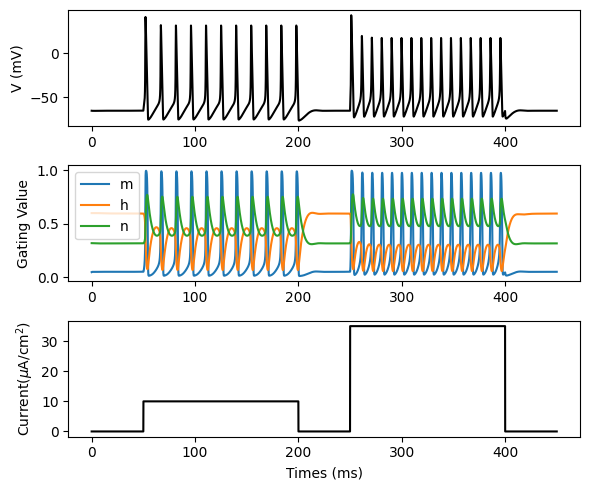

In [5]:
figure(figsize=(6, 5))
subplot(3,1,1); plot(t, varr[:, 1], color="black"); ylabel("V (mV)")
subplot(3,1,2); labellist=["m" "h" "n"] 
for i in 1:3
    plot(t, gatearr[:, i, 1], label=labellist[i])
end; 
ylabel("Gating Value"); legend()
subplot(3,1,3); plot(t, Ie[:, 1], color="black"); ylabel(L"Current($\mu$A/cm$^2$)"); xlabel("Times (ms)")
tight_layout()

In [6]:
spike = (varr[1:nt-1, :] .< 0) .& (varr[2:nt, :] .> 0)
num_spikes = sum(spike, dims=1)
println("Num. of spikes : ", num_spikes[1])

Num. of spikes : 27


In [7]:
T = 1000 # ms
dt = 0.01 # ms
nt = Int(T/dt) # number of timesteps

N = 100 # ニューロンの数

# 入力刺激
mincurrent, maxcurrent = 1, 30
t = (1:nt)*dt
Ie_range = Array{Float32}(range(mincurrent, maxcurrent, length=N)) # injection current

# modelの定義
neurons = HH{Float32}(N=N)

# 記録用
varr_fi = zeros(Float32, nt, N)

# simulation
for i = 1:nt
    update!(neurons, neurons.param, Ie_range, dt)
    varr_fi[i, :] = neurons.v
end

In [8]:
spike = (varr_fi[1:nt-1, :] .< 0) .& (varr_fi[2:nt, :] .> 0)
num_spikes = sum(spike, dims=1)
rate = num_spikes/T*1e3;

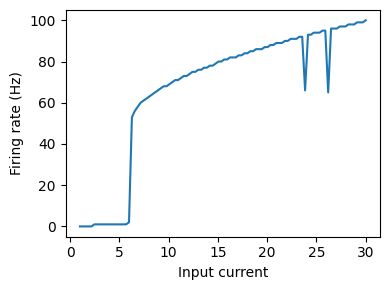

In [9]:
figure(figsize=(4, 3))
plot(Ie_range[:], rate[1, :]); xlabel("Input current"); ylabel("Firing rate (Hz)")
tight_layout()

In [10]:
T = 450 # ms
dt = 0.01 # ms
nt = Int(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
Ie = repeat(10f0 * (-(t .> 50) + (t .> 200)) + 20f0 * (-(t .> 250) + (t .> 400)), 1, N)  # injection current

# modelの定義
neurons = HH{Float32}(N=N)

# 記録用
varr2, gatearr2 = zeros(nt, N), zeros(nt, 3, N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie[i, :], dt)
    varr2[i, :] = neurons.v
    gatearr2[i, :, :] .= [neurons.m; neurons.h; neurons.n]
end

  0.113947 seconds (940.91 k allocations: 25.344 MiB)


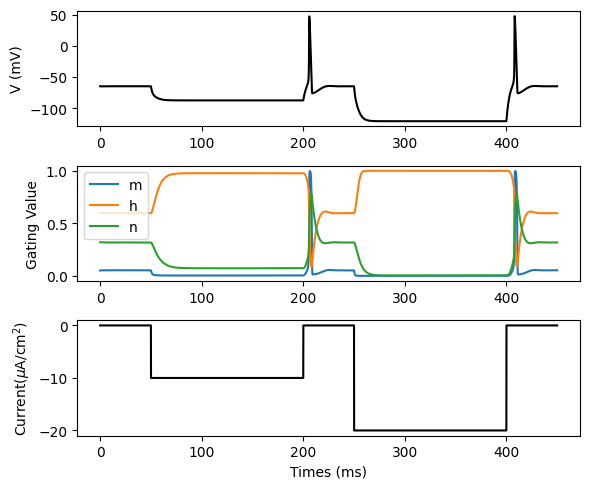

In [11]:
figure(figsize=(6, 5))
subplot(3,1,1); plot(t, varr2[:, 1], color="black"); ylabel("V (mV)")
subplot(3,1,2); labellist=["m" "h" "n"] 
for i in 1:3
    plot(t, gatearr2[:, i, 1], label=labellist[i])
end; 
ylabel("Gating Value"); legend()
subplot(3,1,3); plot(t, Ie[:, 1], color="black"); ylabel(L"Current($\mu$A/cm$^2$)"); xlabel("Times (ms)")
tight_layout()